In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from tqdm import tqdm
from sklearn.ensemble import GradientBoostingClassifier as gbm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.utils import resample


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
ny_flat_data = '/content/drive/My Drive/GaTech/Spring 2020/Machine Learning/data/data_with_features_New_York.csv'
chi_flat_hotel_data = '/content/drive/My Drive/GaTech/Spring 2020/Machine Learning/data/chicago_features_hotels.csv'
chi_flat_rest_data = '/content/drive/My Drive/GaTech/Spring 2020/Machine Learning/data/chicago_features_restaurants.csv'

nyData = pd.read_csv(ny_flat_data)
chiHotelData = pd.read_csv(chi_flat_hotel_data)
chiRestaurantData = pd.read_csv(chi_flat_rest_data)

nyData['label'] = nyData['label'].map({-1: 0, 1: 1})
chiHotelData['label'] = chiHotelData['label'].map({'Y': 1, 'N': 0})
chiHotelData = chiHotelData[chiHotelData.zip_code != "Oops!"]
chiRestaurantData['label'] = chiRestaurantData['label'].map({'Y': 1, 'N': 0})
chiRestaurantData = chiRestaurantData[chiRestaurantData.zip_code != "Oops!"]

nyData = nyData.rename(columns={
    "zipcode": "zip_code", 
    'max_review_per_user_each_day': 'num_review_per_user_each_day',
    'max_review_per_prod_each_day': 'num_review_per_prod_each_day'
    })


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [0]:
################## Keep relevant features ##########################

columns_we_need = [ 'label', 'latitude', 'longitude', 'zip_code', 'review_count', 
                   'review_len', 'review_char', 'punct_count', 'uppercase_count', 'review_per_user',
                   'avg_rating_per_user', 'avg_words_per_user', 'num_review_per_user_each_day', 'review_per_prod',
                   'avg_rating_per_prod', 'avg_words_per_prod', 'num_review_per_prod_each_day']

nyData = nyData[columns_we_need]
chiHotelData = chiHotelData[columns_we_need]
chiRestaurantData  = chiRestaurantData[columns_we_need]

full_data_raw = pd.concat([nyData, chiHotelData, chiRestaurantData])

In [10]:
#Data balancing

# Separate majority and minority classes
df_majority = full_data_raw[full_data_raw.label==1]
df_minority = full_data_raw[full_data_raw.label==0]

print(len(df_minority))
print(len(df_majority))

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=330482,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.label.value_counts()

full_data = df_upsampled


93882
330482


In [0]:
################## Apply to model ######################

train, test = train_test_split(full_data) # full_data_raw full_data
xTrain, yTrain = train.drop('label', axis=1), train['label']
xTest, yTest = test.drop('label', axis=1), test['label']

scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(xTrain)
X_test_scale = scaler.transform(xTest)

X_train_sub, X_validation_sub, y_train_sub, y_validation_sub = train_test_split(X_train_scale, yTrain, random_state=0)

n_est = 80
max_d = 4
learning_rates = [0.10, 0.25, 0.50, 0.70, 0.80, 1]
for learning_rate in learning_rates:
    gb = gbm(n_estimators=n_est, learning_rate = learning_rate, max_features=2, max_depth=max_d, random_state = 0)
    gb.fit(X_train_sub, y_train_sub)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train_sub, y_train_sub)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_validation_sub, y_validation_sub)))
    print()

gb = gbm(n_estimators=n_est, learning_rate = 0.80, max_features=2, max_depth=max_d, random_state = 0)
gb.fit(X_train_sub, y_train_sub)
predictions = gb.predict(X_validation_sub)

print("Classification Report")
print(classification_report(y_validation_sub, predictions))

y_scores_gb = gb.decision_function(X_validation_sub)
fpr_gb, tpr_gb, thresholds = roc_curve(y_validation_sub, y_scores_gb)
roc_auc_gb = roc_auc_score(y_validation_sub, y_scores_gb)


Learning rate:  0.1
Accuracy score (training): 0.817
Accuracy score (validation): 0.815

Learning rate:  0.25
Accuracy score (training): 0.824
Accuracy score (validation): 0.819

Learning rate:  0.5
Accuracy score (training): 0.830
Accuracy score (validation): 0.824

Learning rate:  0.7
Accuracy score (training): 0.830
Accuracy score (validation): 0.824

Learning rate:  0.8
Accuracy score (training): 0.830
Accuracy score (validation): 0.823

Learning rate:  1
Accuracy score (training): 0.829
Accuracy score (validation): 0.823

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.79      0.82     62029
           1       0.80      0.86      0.83     61902

    accuracy                           0.82    123931
   macro avg       0.82      0.82      0.82    123931
weighted avg       0.82      0.82      0.82    123931



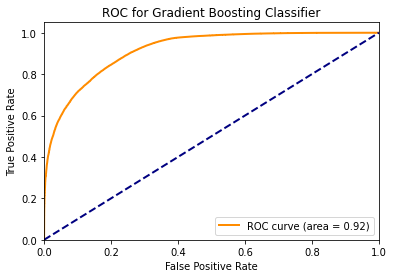

In [0]:
plt.figure()
lw = 2
plt.plot(fpr_gb, tpr_gb, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_gb)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Gradient Boosting Classifier')
plt.legend(loc="lower right")
plt.show()



Text(0.5, 257.44, 'Predicted label')

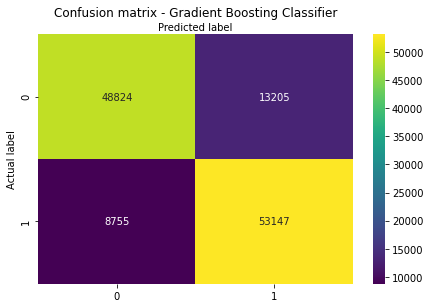

In [0]:
class_names=["True","False"]
cnf_matrix = confusion_matrix(y_validation_sub, predictions)
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix - Gradient Boosting Classifier', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

